## Genetic compression search on LeNet-5 

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import os
import math

from data.mnist import MnistDataset
from models.lenet.lenet import LeNet5
from utils.train import *
from utils.weight_sharing import *
from utils.genetic import GeneticController
from utils.plot import *

Setting some global parameters (for the genetic search settings look in `utils.genetic_config.py`)

In [2]:
# net train settings
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = 'cpu'
EPOCHS = 100

# net save settings 
NET_PATH = './models/lenet/saves/lenet.save'

# ga iter count
NUM_GENERATIONS = 36
NUM_PULATION = 12

# ga search settings
CHROMOSOME_RANGES = [range(1, 51) for _ in range(5)]

# ga save settings
SAVE_EVOL_FILE = './results/test_GA_save.csv'
SAVE_EVERY = 1

# range optimization settings
RANGE_OPTIMIZATION = True
RANGE_OPTIMIZATION_FILE = './results/lenet-layer-perf.csv'

# range optimization settings
SHARE_ORDER = [0, 1, 2, 3, 4]
RETRAIN_AMOUNT = [0, 0, 0, 0, 0]
PREC_REDUCT = None # ['f4', 'f4', 'f4', 'f4', 'f4']

Geting somewhat trained LeNet-5

In [3]:
dataset = MnistDataset(BATCH_SIZE, './data', val_split=0.5)
model = LeNet5(N_CLASSES)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_settings = [criterion, optimizer, dataset, EPOCHS, DEVICE, 1, True]

get_trained(model, NET_PATH, train_settings, DEVICE)

before_loss = get_accuracy(model, dataset.test_dl, DEVICE)

Setting weight share controller

In [4]:
lam_opt = lambda mod : torch.optim.Adam(mod.parameters(), lr=LEARNING_RATE)
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)
lam_test = lambda : get_accuracy(model, dataset.test_dl, DEVICE)

ws_controller = WeightShare(model, lam_opt, lam_train, lam_test)

ws_controller.print_layers_info()

layer_name #weights #bias w_locked CR
feature_extractor.0 150 6 False 1.00
feature_extractor.3 2400 16 False 1.00
feature_extractor.6 48000 120 False 1.00
classifier.0 10080 84 False 1.00
classifier.2 840 10 False 1.00
Sum num weights, bias:  61470 236
Compression rate 1.00


Defining fitness function

In [5]:
def fitness_fc(individual):
    # reset the net
    get_trained(model, NET_PATH, train_settings, DEVICE)
    ws_controller.reset()
    
    # share weigts by chromosome
    individual.data = ws_controller.share(individual.chromosome, SHARE_ORDER, RETRAIN_AMOUNT, PREC_REDUCT)

    if individual.data['accuracy'] <= 0.95:
        return individual.data['accuracy']

    return 1 / math.sqrt(pow(1 - ((individual.data['accuracy'] - 0.9) * (1/0.1)), 2) + pow(1 - (individual.data['compression']/14), 2))


Defining logging function and elit dealing function

In [6]:
data = {
    'generation': [],
    'fitness': [],
    'chromosome': [],
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'share_t': [],
    'train_t': [],
    'acc_t': []
}

data_types = {
    'generation' : 'uint8',
    'fitness': 'float32',
    'accuracy': 'float32',
    'accuracy_loss': 'float32',
    'compression': 'float32',
    'share_t': 'float32',
    'train_t': 'float32',
    'acc_t': 'float32'
}

evol_data = pd.read_csv(SAVE_EVOL_FILE).astype(data_types) if os.path.exists(SAVE_EVOL_FILE) else pd.DataFrame(data).astype(data_types)

def logger_fc(gen_cont:GeneticController):
    global evol_data

    new_data = copy.deepcopy(data)

    for indiv in gen_cont.population:

        new_data['generation'].append(gen_cont.generation)
        new_data['fitness'].append(indiv.fitness)
        new_data['chromosome'].append(indiv.chromosome)
        new_data['accuracy'].append(indiv.data['accuracy'])
        new_data['accuracy_loss'].append(before_loss - indiv.data['accuracy'])
        new_data['compression'].append(indiv.data['compression'])
        new_data['share_t'].append(indiv.data['times']['share'])
        new_data['train_t'].append(indiv.data['times']['train'])
        new_data['acc_t'].append(indiv.data['times']['test'])

    # saving progress
    evol_data = evol_data.append(pd.DataFrame(new_data).astype(data_types))
    if gen_cont.generation % SAVE_EVERY == SAVE_EVERY - 1:
        evol_data.reset_index(drop=True, inplace=True)
        os.makedirs(os.path.dirname(SAVE_EVOL_FILE), exist_ok=True)
        evol_data.to_csv(SAVE_EVOL_FILE, index=False)
    
def deal_elit(population):
    for individual in population:
        if individual.data is not None:
            individual.data['times'] = {
                'share': 0,
                'train': 0,
                'test': 0
            }


Setting ranges with optimization

In [7]:
lam_test_inp = lambda _ : get_accuracy(model, dataset.test_dl, DEVICE)

if RANGE_OPTIMIZATION:
    CHROMOSOME_RANGES = ws_controller.get_optimized_layer_ranges(CHROMOSOME_RANGES, lam_test_inp, 0.97, savefile=RANGE_OPTIMIZATION_FILE, device=DEVICE)

CHROMOSOME_RANGES

[[2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 [4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 [4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 [3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30

Run evolution

In [8]:
genetic = GeneticController(CHROMOSOME_RANGES, NUM_PULATION, fitness_fc)

if evol_data.size != 0:
    genetic.load_from_pd(evol_data)

genetic.run(NUM_GENERATIONS, logger_fc, deal_elit=deal_elit, verbose=True)

Generation 1/36 (1) evaluated, best fitness 2.000454668818294
Generation 2/36 (2) evaluated, best fitness 2.000454668818294
Generation 3/36 (3) evaluated, best fitness 2.000454668818294
Generation 4/36 (4) evaluated, best fitness 2.000454668818294
Generation 5/36 (5) evaluated, best fitness 2.083952469767314
Generation 6/36 (6) evaluated, best fitness 2.083952469767314
Generation 7/36 (7) evaluated, best fitness 2.083952469767314
Generation 8/36 (8) evaluated, best fitness 2.2022104081913563
Generation 9/36 (9) evaluated, best fitness 2.2022104081913563
Generation 10/36 (10) evaluated, best fitness 2.2022104081913563
Generation 11/36 (11) evaluated, best fitness 2.230020209567636
Generation 12/36 (12) evaluated, best fitness 2.230020209567636
Generation 13/36 (13) evaluated, best fitness 2.230020209567636
Generation 14/36 (14) evaluated, best fitness 2.4981494770177317
Generation 15/36 (15) evaluated, best fitness 2.4981494770177317
Generation 16/36 (16) evaluated, best fitness 3.09756

[2, 19, 7, 31, 4]

See output

In [9]:
evol_data

,generation,fitness,chromosome,accuracy,accuracy_loss,compression,share_t,train_t,acc_t
0,0,2.000455,"[17, 26, 4, 22, 16]",0.9782,0.0064,7.702141,0.523485,0.0,3.842344
1,0,1.910676,"[24, 5, 5, 6, 36]",0.9726,0.0120,7.757108,0.403857,0.0,3.412157
2,0,1.892681,"[31, 5, 8, 20, 10]",0.9758,0.0088,7.424607,0.560942,0.0,3.350111
3,0,1.809844,"[6, 11, 19, 11, 49]",0.9832,0.0014,6.630765,0.805334,0.0,3.256306
4,0,1.719480,"[29, 39, 34, 12, 5]",0.9850,-0.0004,6.133484,1.214548,0.0,3.251271
...,...,...,...,...,...,...,...,...,...
427,35,1.856192,"[4, 19, 17, 45, 23]",0.9842,0.0004,6.789333,0.940431,0.0,3.334193
428,35,1.811332,"[40, 19, 4, 31, 47]",0.9792,0.0054,6.840425,0.604175,0.0,3.264626
429,35,1.614216,"[37, 19, 17, 31, 12]",0.9854,-0.0008,5.571362,0.869198,0.0,3.253373
430,35,1.559385,"[26, 33, 48, 31, 12]",0.9850,-0.0004,5.271160,1.647751,0.0,3.285524


Plotting data

Text(0.5, 1.0, 'Genetic Algorithm on LeNet-5')

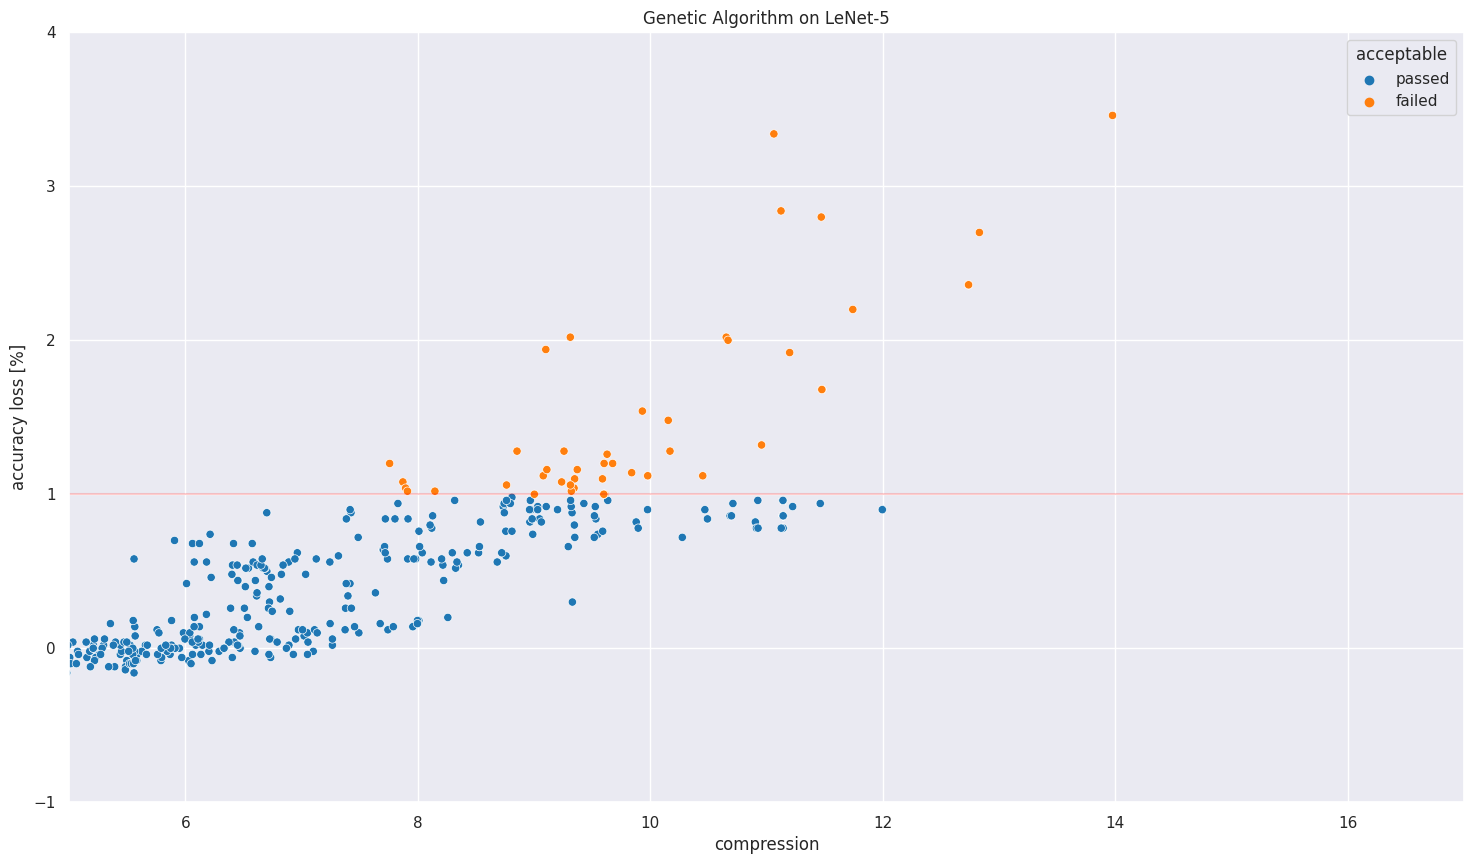

In [10]:
plot_alcr(evol_data)
plt.title('Genetic Algorithm on LeNet-5')